In [1]:
import numpy as np
import cv2
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial import Delaunay


In [2]:
import os
import random
def get_random_index(start, end, n, seed = -1):
    if seed == -1:
        random.seed()
    else:
        random.seed(seed)
    return sorted(random.sample(range(start, end), n))

In [3]:
# generate embeddings
from facenet_pytorch import MTCNN, InceptionResnetV1

mtcnn = MTCNN(keep_all=True)

# load resnet from pretrained model 20180402-114759-vggface2.pt
resnet = InceptionResnetV1(pretrained='vggface2').eval()

/home/hp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def area(a, b, c):
    return abs((a[0]*(b[1]-c[1]) + b[0]*(c[1]-a[1]) + c[0]*(a[1]-b[1]))/2)


def inTriangle(p, a, b, c):
    A = area(a, b, c)
    A1 = area(p, b, c)
    A2 = area(a, p, c)
    A3 = area(a, b, p)
    return A == A1 + A2 + A3


def transfer_coordinates(I, F, p1, p2):
    min_x = max(np.min(p2[:, 0]), 0)
    max_x = min(np.max(p2[:, 0]), I.shape[0]-1)
    min_y = max(np.min(p2[:, 1]), 0)
    max_y = min(np.max(p2[:, 1]), I.shape[1]-1)

    for i in range(min_x, max_x):
        for j in range(min_y, max_y):
            if not inTriangle((i, j), p2[0], p2[1], p2[2]):
                continue
            ar = area(p2[0], p2[1], p2[2])
            if ar == 0:
                continue
            wa = area(p2[1], p2[2], (i, j))/area(p2[0], p2[1], p2[2])
            wb = area(p2[2], p2[0], (i, j))/area(p2[0], p2[1], p2[2])
            wc = 1 - wa - wb

            x1 = int(wa * p1[0, 0] + wb * p1[1, 0] + wc * p1[2, 0])
            y1 = int(wa * p1[0, 1] + wb * p1[1, 1] + wc * p1[2, 1])
            
            if 0 <= x1 < I.shape[1] and 0 <= y1 < I.shape[0]:
                F[j, i] = I[y1, x1]
    return F


def barycentric_method(I, tri, p1, p2):
    result = I.copy()
    for i in range(len(tri.simplices)):
        pa = p1[tri.simplices[i]]
        pb = p2[tri.simplices[i]]
        result = transfer_coordinates(I, result, pa, pb)
    return result


def get_points(img):
    plt.imshow(img)
    plt.axis('on')
    points = np.array(plt.ginput(3)).astype(int)
    plt.close()
    return points


def show_triangles(img, tri, points):
    plt.imshow(img)
    plt.triplot(points.points[:, 0], points.points[:, 1], tri.simplices)
    plt.show()

def generate_regular_grid(image_shape, block_size):
    grid = []
    rows = image_shape[0]
    cols = image_shape[1]
    for i in range(0, rows+block_size-1, block_size):
        grid_row = []
        for j in range(0, cols+block_size-1, block_size):
            grid_row.append((min(i, rows-1),min(j, cols-1)))
        grid.append(grid_row)
    return np.array(grid)

def distort_grid(grid, distortion_factor=5, seed=0):
    np.random.seed(seed)
    distorted = grid + np.random.randint(-distortion_factor, distortion_factor+1, grid.shape)

    # Keep all boundary points the same
    distorted[0, :] = grid[0, :]
    distorted[-1, :] = grid[-1, :]
    distorted[:, 0] = grid[:, 0]
    distorted[:, -1] = grid[:, -1]
    
    return distorted




In [5]:
def mesh_warping(image, block_size, key, maximum_pixel_offset, k_size = 15):
    if block_size == 0:
        warped_image = image.copy()
    else:
        rows, cols = image.shape[:2]

        warped_image = np.zeros_like(image)
        np.random.seed(key)

        grid = generate_regular_grid(image.shape, block_size)
        distorted_grid = distort_grid(grid, maximum_pixel_offset, key)
        p1 = grid.reshape(-1, 2)
        p2 = distorted_grid.reshape(-1, 2)

        tri = Delaunay(p2)
        warped_image = barycentric_method(image, tri, p1, p2)
        
    if k_size != 0:
        kernel_size = (k_size, k_size)  # Increase the kernel size for more smoothing
        smoothed_image = cv2.GaussianBlur(warped_image, kernel_size, 0)
    else:
        smoothed_image = warped_image

    return smoothed_image

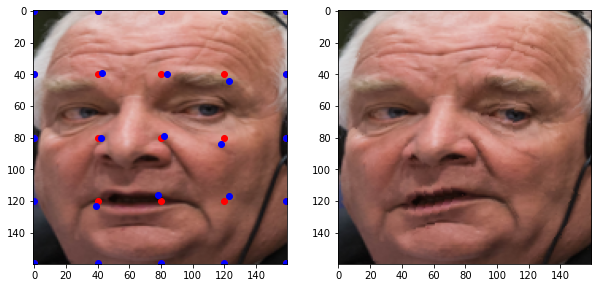

In [6]:
I = cv2.imread('ffhq256_pp/test/images/69001.png', cv2.IMREAD_COLOR)
blocksize = 40
distortion = 4
seed = 2
grid = generate_regular_grid(I.shape, blocksize)
distorted_grid = distort_grid(grid, distortion, seed)
p1 = grid.reshape(-1, 2)
p2 = distorted_grid.reshape(-1, 2)
 
# get corresponding triangles by delaunay triangulation
tri = Delaunay(p1) # will be followed for all images
print(tri)

I_mut = barycentric_method(I, tri, p1, p2)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
for i in range(p1.shape[0]):
    ax[0].scatter(p1[i, 0], p1[i, 1], c='r')
    ax[0].scatter(p2[i, 0], p2[i, 1], c='b')
ax[1].imshow(cv2.cvtColor(I_mut, cv2.COLOR_BGR2RGB))
plt.show()


In [7]:
read_folder = "datasets/ffhq256"
block_size = 20
maximum_pixel_offset = 3
k_size = 0
key = 1234
seed = 0

# create save folder
save_folder = "warped_dataset/{}_{}_{}".format(block_size, maximum_pixel_offset, k_size)

if not os.path.exists(save_folder):
    print("Creating folder: ", save_folder)
    os.makedirs(save_folder)

# create sub folder for train and test
if not os.path.exists(save_folder + "/train/images"):
    os.makedirs(save_folder + "/train/images")
    os.makedirs(save_folder + "/train/embeddings")
if not os.path.exists(save_folder + "/test/images"):
    os.makedirs(save_folder + "/test/images")
    os.makedirs(save_folder + "/test/embeddings")

# sample 1000 images for train and test
train_samples = get_random_index(0,68999,1000,seed)
test_samples = range(69000, 70000)

# warp images
for i in train_samples:
    img = cv2.imread(read_folder + "/{:05d}.png".format(i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    warped_image = mesh_warping(img, block_size, key, maximum_pixel_offset, k_size)

    img_cropped = mtcnn(warped_image, save_path = save_folder + "/train/images/{:05d}.png".format(i))

    if img_cropped is None:
        print("No face detected in image: ", i)
        continue
    if img_cropped.shape[0] > 1:
        for j in range(1, img_cropped.shape[0]):
            os.remove(save_folder + "/train/images/{:05d}_{}.png".format(i,j+1))

        img_cropped = img_cropped[0]

    img_cropped = img_cropped.reshape(1,3, 160, 160)

    try:
        img_embedding = resnet(img_cropped)
    except:
        print('Error in processing image:',i)
        # remove the image copy
        os.remove(save_folder + "/train/images/{:05d}.png".format(i))
        continue

    embedding = img_embedding.detach().numpy()
    file_name = save_folder + "/train/embeddings/{:05d}.npy".format(i)
    np.save(file_name, embedding)
    

for i in test_samples:
    img = cv2.imread(read_folder + "/{:05d}.png".format(i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    warped_image = mesh_warping(img, block_size, key, maximum_pixel_offset, k_size)

    img_cropped = mtcnn(warped_image, save_path = save_folder + "/test/images/{:05d}.png".format(i))

    if img_cropped is None:
        print("No face detected in image: ", i)
        continue
    if img_cropped.shape[0] > 1:
        for j in range(1, img_cropped.shape[0]):
            os.remove(save_folder + "/test/images/{:05d}_{}.png".format(i,j+1))

        img_cropped = img_cropped[0]

    img_cropped = img_cropped.reshape(1,3, 160, 160)

    try:
        img_embedding = resnet(img_cropped)
    except:
        print('Error in processing image:',i)
        # remove the image copy
        os.remove(save_folder + "/test/images/{:05d}.png".format(i))
        continue

    embedding = img_embedding.detach().numpy()
    file_name = save_folder + "/test/embeddings/{:05d}.npy".format(i)
    np.save(file_name, embedding)


Creating folder:  warped_dataset/20_3_0


[ WARN:0@6.637] global loadsave.cpp:248 findDecoder imread_('datasets/ffhq256/00009.png'): can't open/read file: check file path/integrity


error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
